In [2]:
%load_ext autoreload 
%autoreload 2

import yaml
import json
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from fusanet_utils.datasets.simulated import SimulatedPoliphonic
from fusanet_utils.datasets.fusa import FUSA_dataset
from fusanet_utils.transforms import Collate_and_transform

scenarios = {0:'square', 1:'park', 2:'waterfront', 3:'market', 4:'street'}
is_scenario = lambda filename: [key for key, scene in scenarios.items() if scene in filename][0]
    
preds_soft, labels, distances, places, names = [], [], [], [], []
experiment_path = Path('../experiments/Poliphonic-PANN-sed-no-pretrained/')
print(experiment_path)
categories = json.load(open(str(experiment_path / 'index_to_name.json')))
model = torch.load(str(experiment_path / 'model.pt'))
model.eval()
params = yaml.safe_load(open(str(experiment_path / 'params.yaml')))

dataset = SimulatedPoliphonic('..', external=True, mini=False)
fusa_dataset = FUSA_dataset(ConcatDataset([dataset]), feature_params=params["features"])
fusa_loader = DataLoader(fusa_dataset, batch_size=10, shuffle=False, pin_memory=True, num_workers=2,
                         collate_fn=Collate_and_transform(params["features"]))
preds_model, labels_model, file_names_model, distances_model = [], [], [], []
with torch.no_grad():
    for sample in tqdm(fusa_loader):
        preds_model.append(model(sample).numpy())
        labels_model.append(sample['label'].numpy())
        file_names_model.append(sample['filename'])
        distances_model.append(sample['distance'].numpy())
preds_soft.append(np.concatenate(preds_model))
labels.append(np.concatenate(labels_model))
names.append(np.concatenate(file_names_model))
distances.append(np.concatenate(distances_model))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
../experiments/Poliphonic-PANN-sed-no-pretrained


  0%|          | 0/10 [00:00<?, ?it/s]

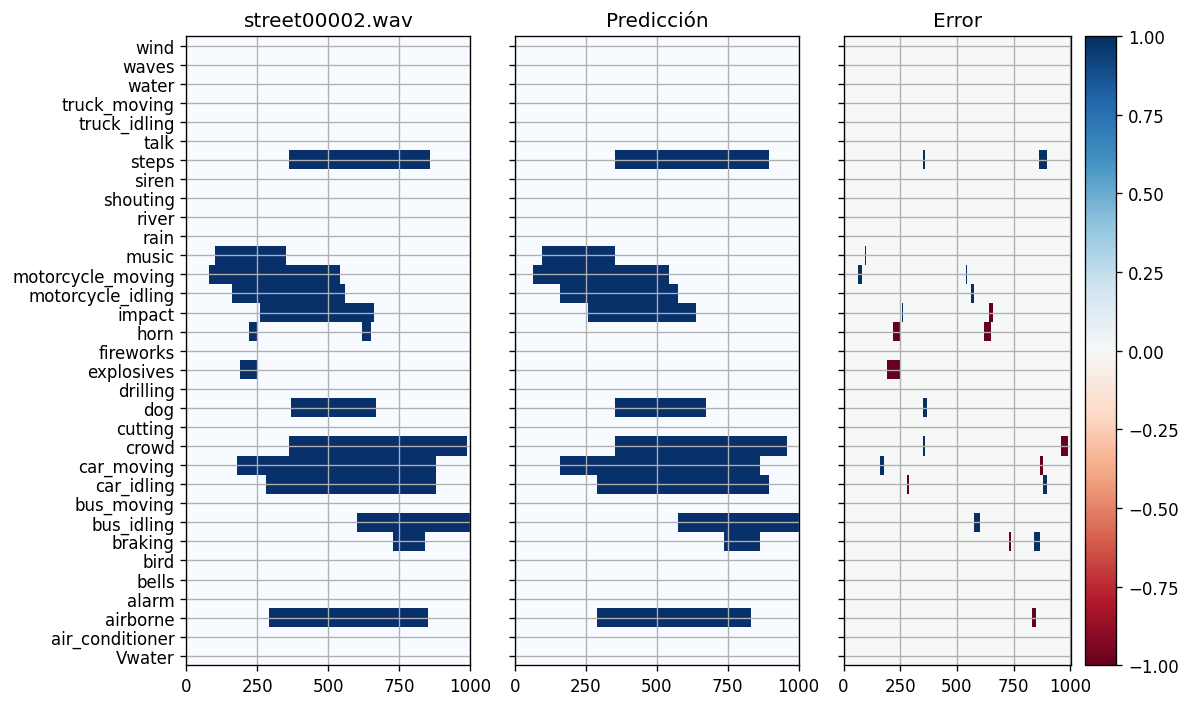

In [2]:
from IPython.display import Audio

def plot_file_prediction(model: int, idx: int, th: float=None):
    if th is not None:
        pred = (preds_soft[model][idx] > th).T#[3:, :]
    
    label = labels[model][idx].T
    fig, ax = plt.subplots(1, 3, figsize=(10, 6), facecolor='w', dpi=120,
                           tight_layout=True, sharex=True, sharey=True)
    ax[0].pcolormesh(label, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[1].pcolormesh(pred, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[0].set_title(names[model][idx])
    ax[1].set_title('Predicción')
    cmap = ax[2].pcolormesh((pred - label), cmap=plt.cm.RdBu, vmin=-1, vmax=1)
    fig.colorbar(cmap)
    ax[2].set_title('Error')
    ax[0].set_yticks(np.arange(0, len(dataset.categories), step=1) + 0.5)
    ax[0].set_yticklabels((dataset.categories));
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    
    return Audio(Path('../datasets/Poliphonic mono external/audios') / names[model][idx])
    
plot_file_prediction(0, 1, 0.3)
#plot_file_prediction(1, 90, 0.3)

In [3]:
th = 0.45
models = ['Kong et al. 2019']
preds = [preds_soft[model] > th for model in range(len(models))]

Por clase para todos los ambientes

In [4]:
import scipy.stats

for k in range(33):
    deletion_mask = ((preds[0]==0) & (labels[0]==1))[:, :, k]
    correct_mask = ((preds[0]==1) & (labels[0] ==1))[:, :, k]
    if distances[0][correct_mask, k].shape[0] == 0:
        continue
    #print(np.median(distances[0][correct_mask, k]), np.median(distances[0][deletion_mask, k]))
    res = scipy.stats.mannwhitneyu(distances[0][correct_mask, k], 
                                   distances[0][deletion_mask, k], 
                                   alternative='less')
    print(list(dataset.categories)[k], ":", res.pvalue < 0.01)

Vwater : True
air_conditioner : True
airborne : True
alarm : True
bells : True
bird : True
braking : True
bus_idling : True
bus_moving : True
car_idling : True
car_moving : False
crowd : True
cutting : True
dog : True
drilling : True
fireworks : False
horn : True
impact : True
motorcycle_idling : True
motorcycle_moving : True
music : True
rain : True
river : False
shouting : True
siren : True
steps : True
talk : True
truck_idling : True
truck_moving : True
water : True
waves : False
wind : True


/home/phuijse/.conda/envs/fusa/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


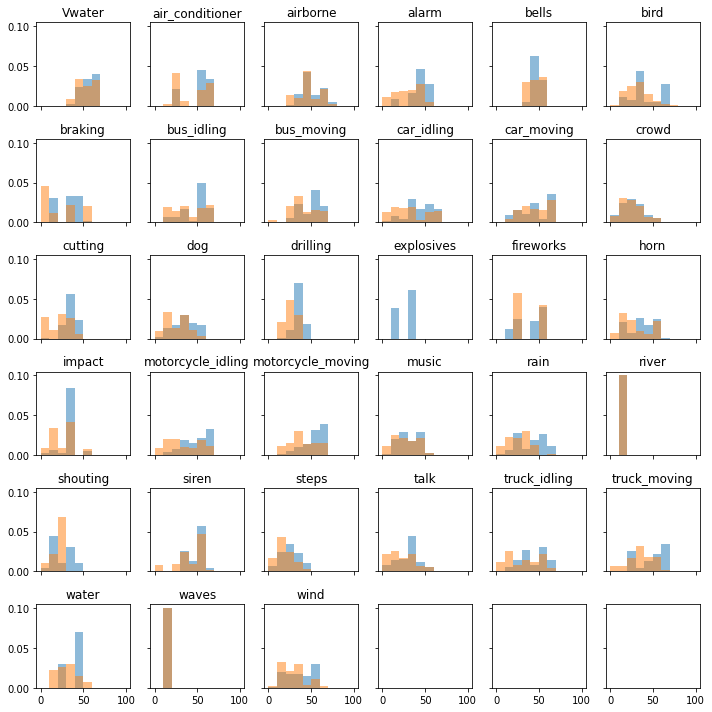

In [5]:
fig, ax = plt.subplots(6, 6, figsize=(10, 10), facecolor='w', sharex=True, sharey=True, tight_layout=True)

for ax_, k in zip(ax.ravel(), range(33)):
    deletion_mask = ((preds[0]==0) & (labels[0]==1))[:, :, k]
    correct_mask = ((preds[0]==1) & (labels[0] ==1))[:, :, k]

    ax_.hist(distances[0][deletion_mask, k], bins=10, alpha=0.5,
             density=True, label='Deletions (FN)', range=(0, 100))
    ax_.hist(distances[0][correct_mask, k], bins=10, alpha=0.5, 
             density=True, label='Detections (TP)', range=(0, 100))
    #ax_.legend()
    #ax_.set_xlabel('Distance to sensor [m]')
    ax_.set_title(list(dataset.categories)[k]);

Text(0.5, 0, 'Distance to sensor [m]')

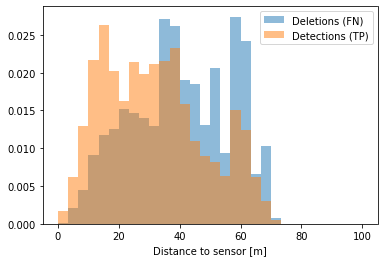

In [8]:
deletion_mask = (preds[0]==0) & (labels[0]==1)
correct_mask = (preds[0]==1) & (labels[0] ==1)
fig, ax = plt.subplots(figsize=(6, 4), facecolor='w')
ax.hist(distances[0][deletion_mask], bins=30, alpha=0.5, density=True, label='Deletions (FN)', range=(0, 100))
ax.hist(distances[0][correct_mask], bins=30, alpha=0.5, density=True, label='Detections (TP)', range=(0, 100))
ax.legend()
ax.set_xlabel('Distance to sensor [m]')


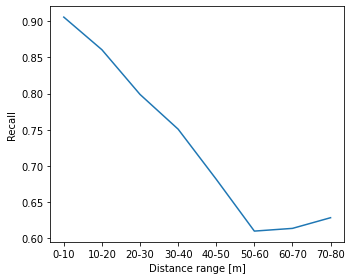

In [22]:
thresholds = [0, 10, 20, 30, 40, 50, 60, 70, 80]
recall = []
for k in range(len(thresholds)-1):
    dist_mask = (distances[0] > thresholds[k]) & (distances[0] <= thresholds[k+1])
    FN = sum(deletion_mask[dist_mask])
    TP = sum(correct_mask[dist_mask])
    recall.append(TP/(TP+FN))
    
fig, ax = plt.subplots(figsize=(5,4),facecolor='w', tight_layout=True)
ax.plot(thresholds[:-1], recall)
ax.set_ylabel('Recall')
ax.set_xlabel('Distance range [m]')
ax.set_xticks(thresholds[:-1])
ax.set_xticklabels([f"{th1}-{th2}" for th1, th2 in zip(thresholds[:-1], thresholds[1:])]);